# Model Training

c:\Users\Nathan\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch 1/18, Training Loss: 1.9090
Epoch 1/18, Validation Loss: 1.8965
Epoch 2/18, Training Loss: 1.6828
Epoch 2/18, Validation Loss: 1.3509
Epoch 3/18, Training Loss: 1.2532
Epoch 3/18, Validation Loss: 1.0170
Epoch 4/18, Training Loss: 0.9241
Epoch 4/18, Validation Loss: 0.9570
Epoch 5/18, Training Loss: 0.7075
Epoch 5/18, Validation Loss: 1.1416
Epoch 6/18, Training Loss: 0.5185
Epoch 6/18, Validation Loss: 0.7672
Epoch 7/18, Training Loss: 0.3794
Epoch 7/18, Validation Loss: 0.9573
Epoch 8/18, Training Loss: 0.2753
Epoch 8/18, Validation Loss: 0.7216
Epoch 9/18, Training Loss: 0.1702
Epoch 9/18, Validation Loss: 0.9839
Epoch 10/18, Training Loss: 0.1309
Epoch 10/18, Validation Loss: 0.7044
Epoch 11/18, Training Loss: 0.1572
Epoch 11/18, Validation Loss: 1.0377
Epoch 12/18, Training Loss: 0.1485
Epoch 12/18, Validation Loss: 0.8844
Epoch 13/18, Training Loss: 0.1352
Epoch 13/18, Validation Loss: 0.7894
Epoch 14/18, Training Loss: 0.0990
Epoch 14/18, Validation Lo

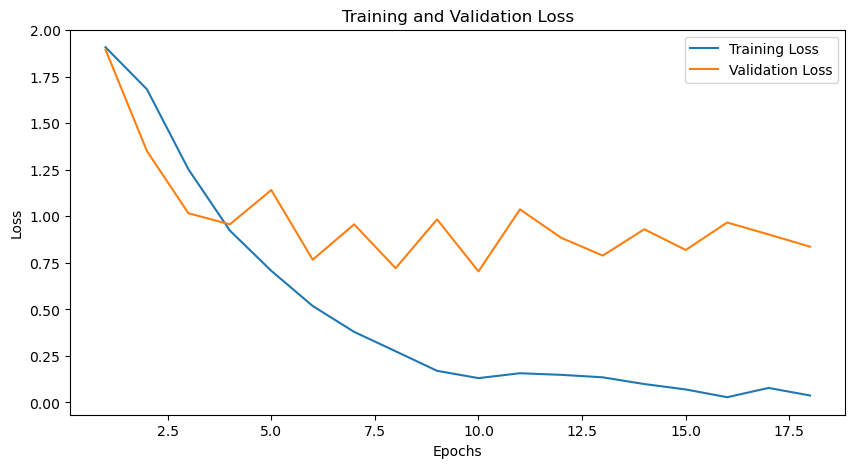

Accuracy for class Blackheads: 62.50%
Accuracy for class Clear Skin: 100.00%
Accuracy for class Cystic: 73.33%
Accuracy for class Papules: 81.08%
Accuracy for class Pustules: 50.00%
Accuracy for class Rosacea: 78.00%
Accuracy for class Whiteheads: 83.33%
Overall Test Accuracy: 75.97%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root="data/train", transform=transform)

# Create indices for training and testing split
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(indices, test_size=0.25, stratify=[full_dataset.targets[i] for i in indices])

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate class weights using sklearn's compute_class_weight
train_labels = [label for _, label in train_loader.dataset]
num_classes = len(set(train_labels))
classes = np.array([i for i in range(num_classes)])
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Load the pre-trained model and modify the final layer
model = models.shufflenet_v2_x0_5(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define the criterion (loss function) with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store the loss for each epoch
train_losses = []
val_losses = []

# Training loop with learning curve tracking
print("Starting training...")
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

# Plotting the learning curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation function to calculate per-class accuracy and overall accuracy
def evaluate_per_class(model, test_loader):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    # Initialize a confusion matrix with zeros
    conf_matrix = np.zeros((len(test_loader.dataset.dataset.classes), len(test_loader.dataset.dataset.classes)))

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Update confusion matrix
            for t, p in zip(labels.view(-1), preds.view(-1)):
                conf_matrix[t.item(), p.item()] += 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy for each class
    class_accuracies = []
    for i in range(len(test_loader.dataset.dataset.classes)):
        class_correct = conf_matrix[i, i]
        class_total = conf_matrix[i].sum()
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_accuracies.append(class_accuracy)
        print(f"Accuracy for class {test_loader.dataset.dataset.classes[i]}: {class_accuracy * 100:.2f}%")

    # Calculate overall accuracy
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    return accuracy, class_accuracies

# Get the class-wise accuracy and overall accuracy
overall_accuracy, class_accuracies = evaluate_per_class(model, test_loader)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")



### Save Model

In [124]:
# Saving
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to model.pth


### Load Model

In [129]:
# Loading
model = models.shufflenet_v2_x0_5(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_save_path))
model = model.to(device)
model.eval()
print("Model loaded.")

Model loaded.


c:\Users\Nathan\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Nathan\AppData\Local\Temp\ipykernel_17168\1879304336.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fli

# RL Testing

In [12]:
import torch
from PIL import Image
from torchvision import transforms, models

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model (make sure you have loaded the weights)
model = models.shufflenet_v2_x0_5(pretrained=False)  # Use the model architecture you trained
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer as needed
model.load_state_dict(torch.load('model.pth'))  # Load the saved model weights
model = model.to(device)  # Move the model to the correct device
model.eval()  # Set the model to evaluation mode

# Replace 'your_image.jpg' with the path to the image you want to classify
image_path = 'data/test/image.jpg'

# Define the image transformations (resize, normalization) for model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 for the model
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load and preprocess the image
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add a batch dimension (1, C, H, W)

# Move the image tensor to the same device as the model
image = image.to(device)

# Perform inference (forward pass)
with torch.no_grad():  # Disable gradient computation during inference
    outputs = model(image)

# Get the predicted class (index of the highest logit)
_, predicted_class = torch.max(outputs, 1)

# Access the classes from the original dataset (ImageFolder or similar)
# Make sure to access the original dataset from train_loader (not the subset)
classes = train_loader.dataset.dataset.classes  # Assuming your loader is a subset
class_label = classes[predicted_class.item()]

print(f"The image is classified as: {class_label}")


The image is classified as: Clear Skin


C:\Users\Nathan\AppData\Local\Temp\ipykernel_7156\568179294.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))  # Load the s